In [ ]:
import os
import cv2
import random
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchvision.models import vgg19, VGG19_Weights

import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print('Using device:', device)

Using device: cuda


In [ ]:
TRAIN_ROOT = 'dataset/train'
patch_size = 224

hr_transform = transforms.Compose([
  transforms.ToImage(),
  transforms.ToDtype(dtype=torch.float32, scale=True),
  transforms.Resize((patch_size, patch_size), interpolation=InterpolationMode.BICUBIC)
])

lr_transform = transforms.Compose([
  transforms.Resize((patch_size // 2, patch_size // 2), interpolation=InterpolationMode.BICUBIC),
])

In [ ]:
class XrayDataset(Dataset):
  def __init__(self, images_path, hr_patch_size, hr_transform, lr_transform):
    self.images_path = images_path
    self.hr_transform = hr_transform
    self.hr_patch_size = hr_patch_size
    self.lr_transform = lr_transform
    self.normalizer = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

  def __len__(self):
    return len(self.images_path)

  def __getitem__(self, index):
    image_path = self.images_path[index]
    hr_image = cv2.imread(image_path, flags=cv2.IMREAD_COLOR_RGB)
    hr_image = torch.tensor(hr_image).permute(2, 0, 1)
    hr_image = self.hr_transform(hr_image)
    lr_image = self.lr_transform(hr_image)
    hr_image = self.normalizer(hr_image)
    lr_image = self.normalizer(lr_image)
    return lr_image, hr_image

In [ ]:
image_dirs = os.listdir(TRAIN_ROOT)
train_image_files = [os.path.join(TRAIN_ROOT, fname) for fname in os.listdir(TRAIN_ROOT)]

train_portion = 0.8
train_size = int(len(train_image_files) * train_portion)
train_image_files, val_image_files = train_image_files[:train_size], train_image_files[train_size:]

train_dataset = XrayDataset(train_image_files, patch_size, hr_transform, lr_transform)
val_dataset = XrayDataset(val_image_files, patch_size, hr_transform, lr_transform)

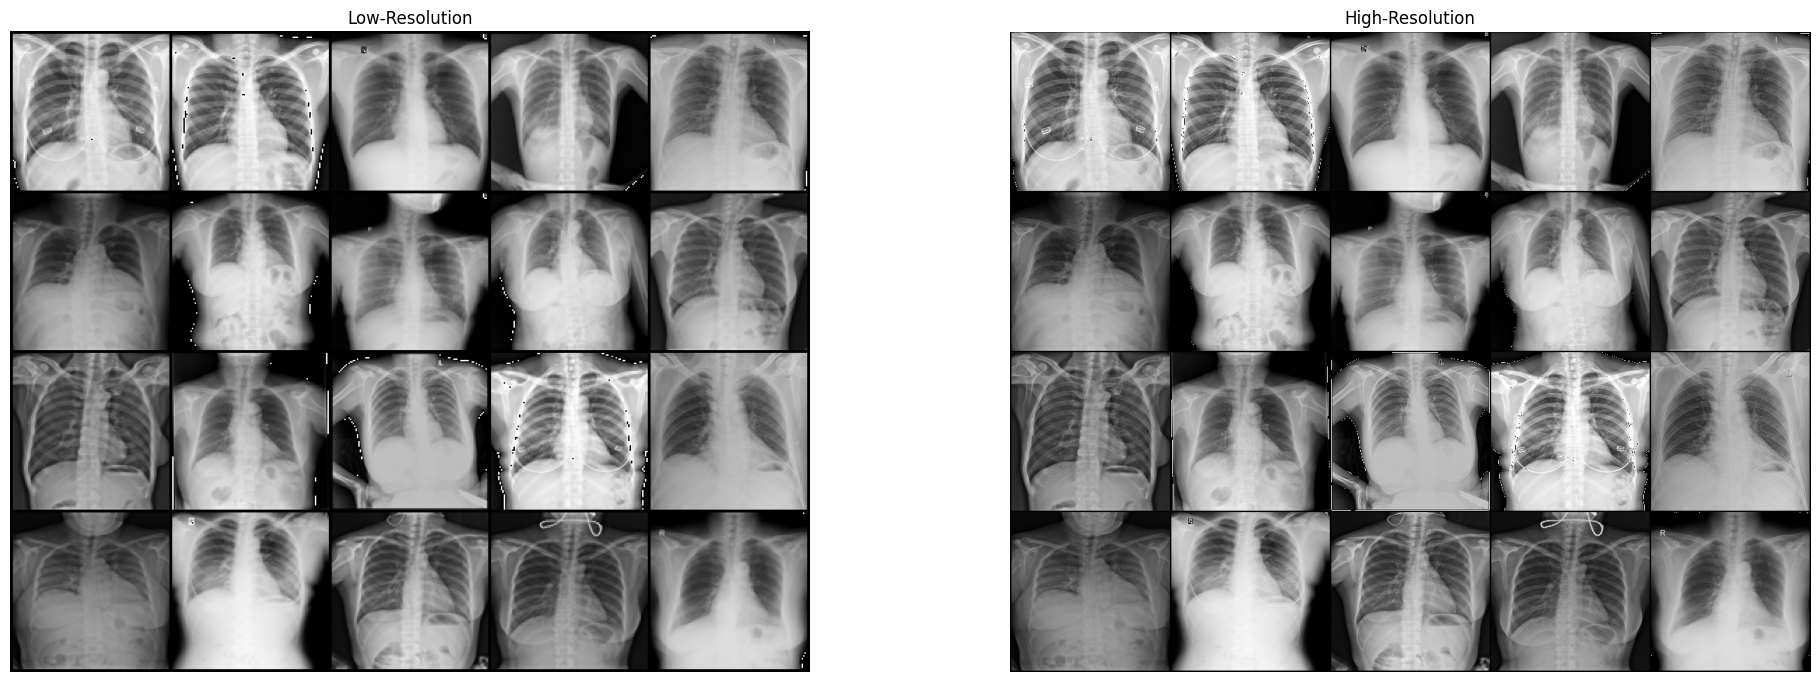

In [9]:
from math import ceil
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def visualize_grid(lr_images, hr_images):
    """
    Visualize LR and HR images in a single grid.

    Args:
        lr_images: List of LR images (as tensors).
        hr_images: List of HR images (as tensors).
    """
    lr_images = [((img * 127.5) + 127.5) for img in lr_images]
    hr_images = [((img * 127.5) + 127.5) for img in hr_images]


    nrow_lr = ceil(len(lr_images) / 4)
    nrow_hr = ceil(len(hr_images) / 4)

    lr_grid = make_grid(torch.stack(lr_images), nrow=nrow_lr, padding=2)
    hr_grid = make_grid(torch.stack(hr_images), nrow=nrow_hr, padding=2)


    fig = plt.figure(figsize=(20, 15))
    ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.8])
    ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.8])
    ax1.imshow(lr_grid.permute(1, 2, 0).type(torch.uint8).cpu().numpy(), cmap="bone")
    ax1.set_title("Low-Resolution")
    ax1.axis("off")


    ax2.imshow(hr_grid.permute(1, 2, 0).type(torch.uint8).cpu().numpy(), cmap="bone")
    ax2.set_title("High-Resolution")
    ax2.axis("off")

    plt.show()


lr_images, hr_images = zip(*[train_dataset[i] for i in range(20)])
visualize_grid(lr_images, hr_images)
del lr_images, hr_images

In [11]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, generator=torch.Generator(device=device))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
import math
leak = 0.2

class Model(nn.Module):
	def __init__(self, *args, **kwargs):
		super().__init__(*args, **kwargs)

	def load_weights(self, weights_path: str):
		self.load_state_dict(torch.load(weights_path, weights_only=True))


class Generator(Model):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.PReLU()
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (F.tanh(block8) + 1) / 2

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return F.sigmoid(self.net(x).view(batch_size, 1))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual

class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        vgg = vgg19(weights=VGG19_Weights.DEFAULT).features[:36].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, x):
        return self.vgg(x)

In [13]:
class SNSRGANLoss(nn.Module):
  def __init__(self, alpha=1, beta=1e-3, _lambda=1e-6, eta=0.1, n=10):
    super(SNSRGANLoss, self).__init__()
    self.alpha = alpha
    self.beta = beta
    self._lambda = _lambda
    self.eta = eta
    self.n = n

    self.vgg = VGGFeatureExtractor()
    self.mse = nn.MSELoss()
    self.bce = nn.BCELoss()

  def conditional_adversarial_loss(self, d_fake):
    return -torch.mean(torch.log(d_fake + 1e-8))

  def pixelwise_mse(self, sr, hr):
    return self.mse(hr, sr)

  def perceptual_loss(self, sr, hr):
    sr_image_features = self.vgg(sr)
    hr_image_features = self.vgg(hr)
    return self.mse(sr_image_features, hr_image_features)

  def total_variation_loss(self, sr):
    diff_h = torch.abs(sr[:, :, 1:, :] - sr[:, :, :-1, :])
    diff_v = torch.abs(sr[:, :, :, 1:] - sr[:, :, :, :-1])
    tv_loss = torch.sum(diff_h**2) + torch.sum(diff_v**2)
    return tv_loss

  def __distance_transform(self, mask):
    mask = (mask > 0).float()
    zero_pixels = (mask == 0).nonzero(as_tuple=False).float()
    h, w = mask.shape
    y_coords, x_coords = torch.meshgrid(torch.arange(h), torch.arange(w))
    coords = torch.stack([y_coords.flatten(), x_coords.flatten()], dim=1).float()

    distances = torch.cdist(coords, zero_pixels, p=2)  # p=2 for Euclidean distance
    min_distances = distances.min(dim=1)[0]  # Find the minimum distance for each pixel

    distance_transform = min_distances.reshape(h, w)
    return distance_transform

  def transform_loss(self, sr, hr):
    mask = torch.randint(0, 2, (patch_size, patch_size)).float()
    dist_transform = self.__distance_transform(mask)
    dist_transform = dist_transform

    # Raise the distance transform to the power of n
    d_con_n = dist_transform ** self.n
    d_con_n = d_con_n.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    loss = 0.5 * torch.mean((sr * d_con_n - hr * d_con_n) ** 2)
    return loss

  def forward(self, sr, hr, d_fake):
    return (
      self.conditional_adversarial_loss(d_fake) + \
      self.alpha * self.pixelwise_mse(sr, hr) + \
      self.beta * self.perceptual_loss(sr, hr) + \
      self._lambda * self.total_variation_loss(sr) + \
      self.eta * self.transform_loss(sr, hr)
    )

In [14]:
train_history = {'g_loss': [], 'd_loss': []}
val_history = {'g_loss': [], 'd_loss': [], 'ssim': [], 'psnr': []}

mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
generator = Generator(scale_factor=2)
discriminator = Discriminator()
criterion = SNSRGANLoss()
ssim = StructuralSimilarityIndexMeasure(data_range=2.0)
psnr = PeakSignalNoiseRatio(data_range=2.0)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

best_ssim = float('inf')
num_epochs = 20

In [ ]:
for epoch in range(len(train_history['g_loss']), len(train_history['g_loss']) + num_epochs):
  print(f"Epoch [{epoch + 1}/{num_epochs}]")
  epoch_start_time = time.time()

  generator.train()
  discriminator.train()

  with tqdm(total=len(train_loader), desc=f"Train Epoch {epoch + 1}/{num_epochs}", unit="batch") as train_pbar:
    for lr_images, hr_images in train_loader:
      optimizer_d.zero_grad()

      fake_hr = generator(lr_images)
      real_labels = torch.ones(hr_images.size(0), 1).to(device)
      fake_labels = torch.zeros(hr_images.size(0), 1).to(device)

      # Compute discriminator losses
      d_real = discriminator(hr_images)
      d_fake = discriminator(fake_hr.detach())
      real_loss = bce_loss(d_real, real_labels)
      fake_loss = bce_loss(d_fake, fake_labels)
      d_loss = real_loss + fake_loss
      d_loss.backward()
      optimizer_d.step()

      # Train Generator
      optimizer_g.zero_grad()

      d_fake = discriminator(fake_hr)  # Recompute for generator loss
      g_loss = criterion(fake_hr, hr_images, d_fake)
      g_loss.backward()
      optimizer_g.step()

      # Update progress bar with training losses
      train_pbar.set_postfix({
          'D Loss': f"{d_loss.item():.4f}",
          'G Loss': f"{g_loss.item():.4f}",
      })
      train_pbar.update(1)


  generator.eval()
  val_d_loss = val_g_loss = val_ssim = val_psnr = 0
  with torch.no_grad():
    with tqdm(total=len(val_loader), desc=f"Validation Epoch {epoch + 1}/{num_epochs}", unit="batch") as val_pbar:
      for lr_images, hr_images in val_loader:

        fake_hr = generator(lr_images)

        real_labels = torch.ones(hr_images.size(0), 1).squeeze(0).to(device)
        fake_labels = torch.zeros(hr_images.size(0), 1).squeeze(0).to(device)
        d_fake = discriminator(fake_hr)
        real_loss = bce_loss(discriminator(hr_images), real_labels)
        fake_loss = bce_loss(d_fake, fake_labels)
        d_loss = real_loss + fake_loss

        val_d_loss += d_loss.item()
        val_g_loss += g_loss.item()

        g_loss = criterion(fake_hr, hr_images, d_fake)

        val_ssim += ssim(fake_hr, hr_images)
        val_psnr += psnr(fake_hr, hr_images)

        val_pbar.set_postfix({
          'D Loss': f"{d_loss.item():.4f}",
          'G Loss': f"{g_loss.item():.4f}",
          'SSIM': f'{val_ssim:.4f}',
          'PSNR': f'{val_psnr:.4f}'
        })
        val_pbar.update(1)

  # Calculate average validation losses
  num_val_batches = len(val_loader)
  val_d_loss /= num_val_batches
  val_g_loss /= num_val_batches
  val_ssim /= num_val_batches  # Average SSIM over all validation batches
  val_psnr /= num_val_batches  # Average PSNR over all validation batches

  train_history['d_loss'].append(d_loss.item())
  train_history['g_loss'].append(g_loss.item())

  val_history['d_loss'].append(val_d_loss)
  val_history['g_loss'].append(val_g_loss)
  val_history['ssim'].append(val_ssim)
  val_history['psnr'].append(val_psnr)

  # End of epoch logging
  epoch_time = time.time() - epoch_start_time
  print(f"Completed in {epoch_time:.2f} seconds.")

  if val_ssim > best_ssim:
    best_ssim = val_ssim
    torch.save(generator.state_dict(), 'pretrained/generator.pt')
    torch.save(discriminator.state_dict(), 'pretrained/discriminator.pt')
    torch.save(optimizer_g.state_dict(), 'pretrained/optimizer_g.pt')
    torch.save(optimizer_d.state_dict(), 'pretrained/optimizer_d.pt')

Epoch [1/20]


Train Epoch 1/20:   0%|          | 0/12000 [00:00<?, ?batch/s]/home/ttalpha/miniconda3/envs/ai/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Train Epoch 1/20:   3%|▎         | 334/12000 [01:51<45:37,  4.26batch/s, D Loss=1.0068, G Loss=38.2360]    